# URAU city loop template

In [1]:
%matplotlib inline

import numpy as np
from shapely.geometry import MultiLineString, MultiPolygon, Polygon, box, shape

import datetime as dt

# Utilities
import boto3
import dateutil
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
import rasterio
# Various utilities
import json
import xarray as xr
import shapely.geometry
import IPython.display
import zarr

# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    ByocCollection,
    ByocCollectionAdditionalData,
    ByocCollectionBand,
    ByocTile,
    DataCollection,
    DownloadFailedException,
    MimeType,
    SentinelHubBYOC,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
    os_utils,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
# from utils import plot_image

config = SHConfig()
config.instance_id = os.environ.get("SH_INSTANCE_ID")
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")
config.aws_access_key_id = os.environ.get("username")
config.aws_secret_access_key = os.environ.get("password")

## Import city bounding boxes

In [2]:
c_bb = pd.read_csv("./../../../s3/data/bboxes/URAU_city_bboxes_4326.csv")
# select cities
cities_list = ["Luxembourg"]
c_bb_subset = c_bb[c_bb['URAU_NAME'].isin(cities_list)]
resolution = 60
for row in c_bb_subset.itertuples():
    bbox_coords = row.minx, row.miny, row.maxx, row.maxy
    print(bbox_coords)
    bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
    bbox_size = bbox_to_dimensions(bbox, resolution=resolution)
    print(f"Image shape at {resolution} m resolution: {bbox_size} pixels")
    break
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

(6.0692, 49.561, 6.2036, 49.6549)
Image shape at 60 m resolution: (168, 168) pixels


<IPython.display.GeoJSON object>

## Collections

In [3]:
# URAU Cities
collection_id_city = "20774d38-7b2e-43e9-b574-66fa2954da1c"
collection_name_city = "urban_audit_2021_city"
data_collection_city = DataCollection.define_byoc(collection_id_city, name=collection_name_city)
# Urban atlas
collection_id_UA = "27c95f8f-fb6b-46f2-8f84-2ce7761eeccd"
collection_name_UA = "UrbanAtlas2018_10m_raster_2"
data_collection_UA = DataCollection.define_byoc(collection_id_UA, name=collection_name_UA)

## Prepare request

In [4]:

evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [
            {
                datasource: "city",
                bands: ["B1"]
            },
            {
                datasource: "UA",
                bands: ["B1"]
            }],
            output: {
                bands: 2,
                sampleType: "UINT16" // raster format will be UINT16
            }
        };
    }

    function evaluatePixel(samples, inputData, inputMetadata, customData, outputMetadata) {
        var sample_city = samples.city[0]
        var sample_ua = samples.UA[0]
        return [sample_city.B1, sample_ua.B1];

      
    }
"""
input_data = [
        SentinelHubRequest.input_data(
            data_collection=DataCollection.urban_audit_2021_city,
            identifier="city",
        ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.UrbanAtlas2018_10m_raster_2,
            identifier="UA",
        )
    ]
def sentinelhub_request(evalscript,input_data, bbox, size, config):
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=input_data,
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=size,
        config=config,
    )
    images = request.get_data()[0]
    return images

## Main loop

In [5]:
for row in c_bb_subset.itertuples():
    bbox_coords = row.minx, row.miny, row.maxx, row.maxy
    bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
    bbox_size = bbox_to_dimensions(bbox, resolution=10)
    subcube = sentinelhub_request(evalscript,input_data, bbox, bbox_size, config)
    break
print(subcube.shape)

(1007, 1011, 2)


## Visualization

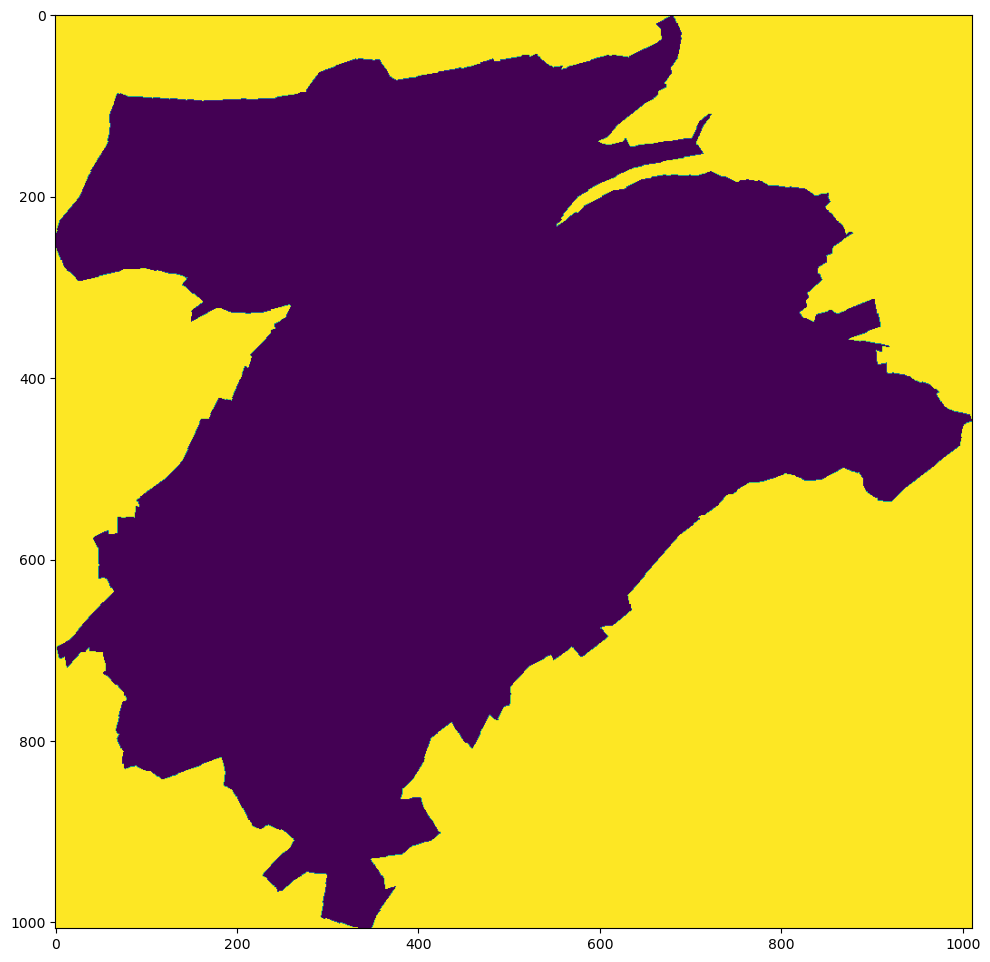

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(subcube[:,:,0])
# ax.set_title(tile_time.date().isoformat(), fontsize=10)

plt.tight_layout()

In [12]:
# explore a subset of the data
subcube[0:200,0:200,0]

array([[65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       ...,
       [65535, 65535, 65535, ...,   597,   597,   597],
       [65535, 65535, 65535, ...,   597,   597,   597],
       [65535, 65535, 65535, ...,   597,   597,   597]], dtype=uint16)

In [22]:
ua_bins = np.unique(subcube[:,:,1]).tolist()
ua_bins.append(50001)
ua_bins

[11100,
 11210,
 11220,
 11230,
 11240,
 11300,
 12100,
 12210,
 12220,
 12230,
 12400,
 13100,
 13300,
 13400,
 14100,
 14200,
 21000,
 22000,
 23000,
 31000,
 32000,
 50000,
 50001]

## Make mask from FUA dimension

In [17]:
d_c = subcube[:,:,0]
d_ua = subcube[:,:,1]

# make a COPY of the vector, otherwise the original vector is overwritten!
mask_c = d_c.copy()
mask_c[mask_c < 65535] = 1
mask_c[mask_c == 65535] = 0

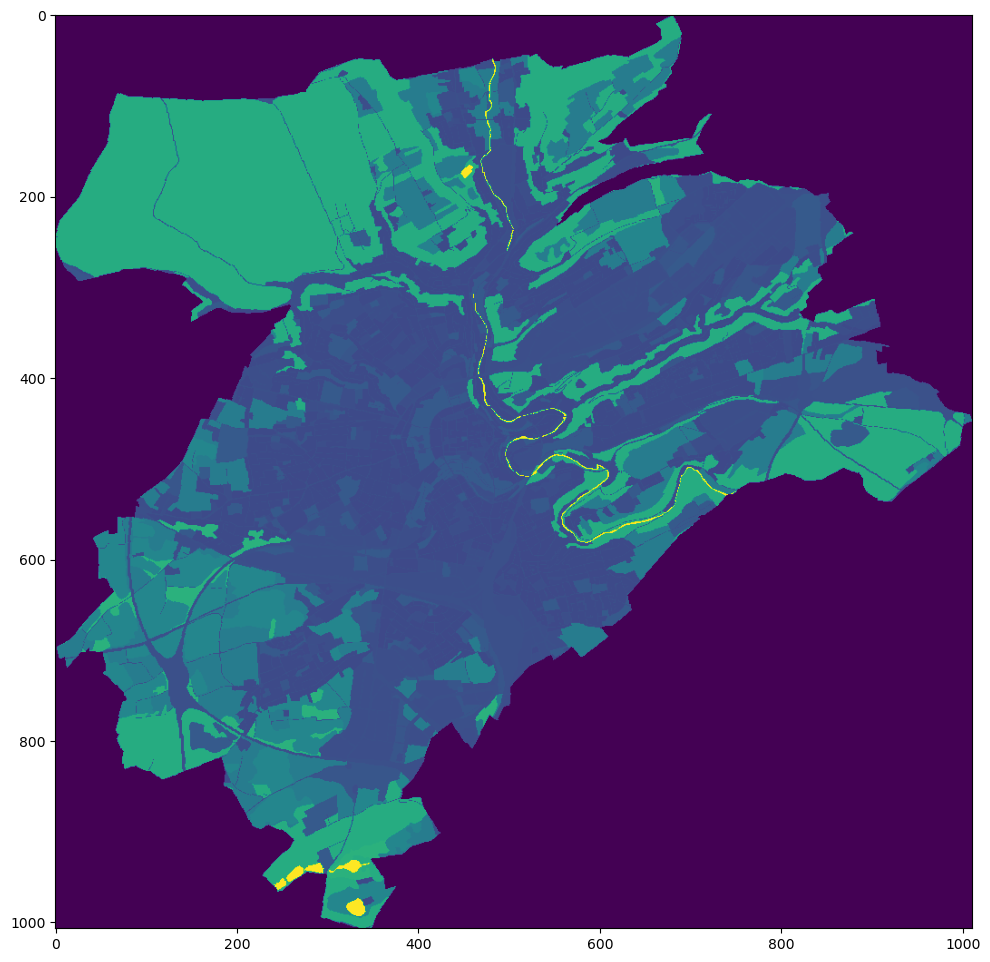

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(d_ua*mask_c)
plt.tight_layout()

In [23]:
ua_lux = d_ua*mask_c
vec = np.histogram(ua_lux, bins=ua_bins)
vec

(array([ 26414,  64249,  16361,   1570,    247,    762,  70209,   6480,
         34180,   6302,   4410,   1683,   3671,   5001,  18702,  10527,
         57211,    323,  36508, 145611,   6405,   2429]),
 array([11100, 11210, 11220, 11230, 11240, 11300, 12100, 12210, 12220,
        12230, 12400, 13100, 13300, 13400, 14100, 14200, 21000, 22000,
        23000, 31000, 32000, 50000, 50001]))

TODO join lookup table to get UA class names

<BarContainer object of 22 artists>

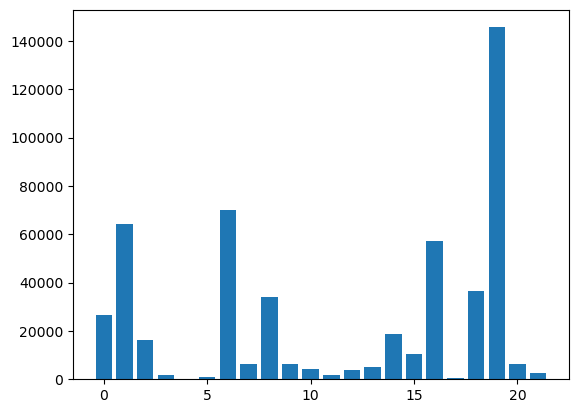

In [36]:
counts, bins = vec
plt.bar(list(range(len(bins)-1)), counts)

TODO save table with UA code and densities

In [38]:
tot = sum(mask_c[mask_c>0])
densities = counts/tot
densities

array([0.05086903, 0.12373304, 0.0315086 , 0.00302356, 0.00047568,
       0.00146749, 0.13521102, 0.01247942, 0.06582508, 0.01213662,
       0.00849294, 0.00324118, 0.00706974, 0.00963111, 0.03601699,
       0.02027328, 0.11017901, 0.00062205, 0.07030842, 0.28042291,
       0.01233498, 0.00467786])